#                              Programming Assignment 2

## CNN on CIFAR-10 dataset

#### Importing necessary packages 

In [1]:
import os
import numpy as np
import pandas as pd
import argparse
import gzip, pickle
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, AlphaDropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical
from keras.regularizers import l2


## Initializing certain hyperparameters. You can tweak the hyperparameters and check how the model trains differently
### Possible values for 
#### 1) init - ("he_normal" or "GlorotNormal")
#### 2) lr - A float number <= 0.1
#### 3) Batch_size - should be 1 or some multiple of 5

In [2]:
init = "he_normal"
lr = 0.001
batch_size = 250 
save_dir = os.curdir
lm = os.path.join(os.curdir, "saved_models/model_2020_07_06_20_38_27(83.23%)")

### Lisiting the contents of the current workspace

In [3]:
os.listdir(os.curdir)

['cifar-10-batches-py',
 '.ipynb_checkpoints',
 'saved_models',
 '.git',
 'ProgrammingAssignment2.ipynb',
 'train.py']

## Load data

In [4]:
# Function to load the pickled format of the file and then concatenating all the 5 batches into a single batch 
    def load_data():
        # Setting seed to a some value so as to have the same random distribution while fitting
        tf.random.set_seed(123)
        np.random.seed(123)

        os.chdir(os.path.join(os.curdir, "cifar-10-batches-py/"))

        # Function to unpickle the pickled file
        def unpickle(file):
            import pickle
            with open(file, 'rb') as fo:
                dict = pickle.load(fo, encoding='bytes')
            return dict

        # Unpickling every batch which are all dictionaries
        data_batch_1 = unpickle('data_batch_1')
        data_batch_2 = unpickle('data_batch_2')
        data_batch_3 = unpickle('data_batch_3')
        data_batch_4 = unpickle('data_batch_4')
        data_batch_5 = unpickle('data_batch_5')
        test_batch = unpickle('test_batch')
        class_names = unpickle('batches.meta')

        # Extracting the train, test batches and class_names from the dictionaries
        train_data_1 = data_batch_1[b'data']
        train_data_2 = data_batch_2[b'data']
        train_data_3 = data_batch_3[b'data']
        train_data_4 = data_batch_4[b'data']
        train_data_5 = data_batch_5[b'data']
        test_data = test_batch[b'data']

        train_lab_1 = data_batch_1[b'labels']
        train_lab_2 = data_batch_2[b'labels']
        train_lab_3 = data_batch_3[b'labels']
        train_lab_4 = data_batch_4[b'labels']
        train_lab_5 = data_batch_5[b'labels']
        test_lab = test_batch[b'labels']

        class_names = class_names[b"label_names"]

        # Concatenating all the train and test batches into a single training and a single test image set respectively
        train_data = tf.concat([train_data_1,train_data_2,train_data_3,train_data_4,train_data_5], 0) 
        train_labels = tf.concat([train_lab_1,train_lab_2,train_lab_3,train_lab_4,train_lab_5], 0)

        return train_data, test_data, train_labels, test_lab, class_names


## Preprocess data 

In [5]:
    def preprocess_data():
        
        # Loads data from load_data() function
        train_data, test_data, train_labels, test_lab, class_names = load_data()

        # Function to resize the image data from m*3072 to m*32*32*3 (where m is 50000 for train set and 10000 for test set)
        # We need some workaround here, because the 3072 elements contain 1024 elements each for red, green, blue channels in that order.
        def resize(data):
            data1 = tf.reshape(data, [-1,3,32,32]).numpy()
            data2 = tf.transpose(data1, perm = [0,2,3,1]).numpy()
            return data2

        # Reshaping train and test images to appropriate shape
        train_images = resize(train_data)
        test_data = resize(test_data)

        # Setting seed to a some value so as to have the same random distribution while fitting
        tf.random.set_seed(123)
        np.random.seed(123)

        X = np.array(train_images)
        y = np.array(train_labels)

        # Using StratifiedShuffleSplit from scikit-learn by first creating its instance and then splitting the train set further into train and validation set
        # 45000 images in train set and 5000 images in validation set
        # Stratified sampling is better than random sampling because this takes care of skewed classes
        split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 123)
        for train_index, val_index in split.split(X,y):
            X_train = X[train_index]
            X_valid = X[val_index]
            y_train = y[train_index]
            y_valid = y[val_index]

        X_test, y_test = np.array(test_data), np.array(test_lab)
        # Normalizing the inputs
        X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0
        
        # Converting labels from sparse to one-hot vectors
        y_train = to_categorical(y_train, num_classes = 10)
        y_valid = to_categorical(y_valid, num_classes = 10)
        y_test = to_categorical(y_test, num_classes = 10)

        return X_train, y_train, X_valid, y_valid, X_test, y_test, class_names    
 

In [6]:
X_train, y_train, X_valid, y_valid, X_test, y_test, class_names = preprocess_data()
# Shifting back to the workspace directory to access all the files
os.chdir(os.pardir)

### Visualizing first 25 images from the train set along with the corresponding labels

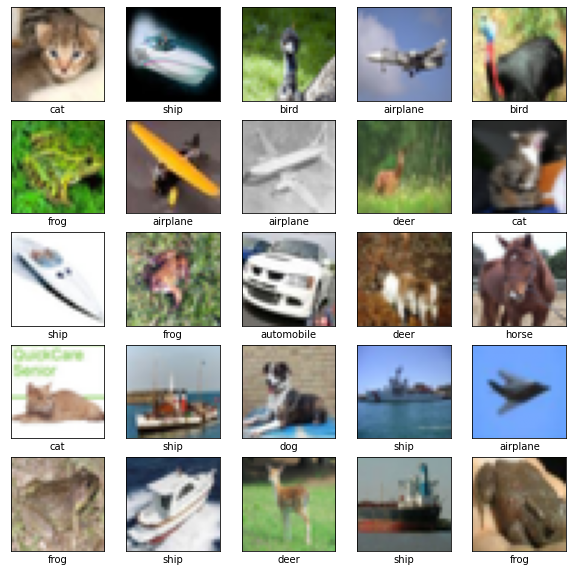

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(y_train[i])].decode("utf-8"))
plt.show()

### Array containing the class names

In [8]:
class_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

### Defining the sequential cnn model

In [9]:
learning_rate = lr
init = init
reg_rate = 1e-3  # This regularization rate seems to give good result, you could also use 5e-4

# Setting seed to a some value so as to have the same random distribution
tf.random.set_seed(123)
np.random.seed(123)

model = Sequential([

                Conv2D(64, 3, strides = 1, padding = "same", activation = "relu", kernel_initializer = init, 
                       bias_initializer='zeros', kernel_regularizer = l2(reg_rate), input_shape = [32,32,3]),

                BatchNormalization(),

                MaxPool2D(pool_size=2, strides = 2),

                Conv2D(128, 3, strides = 1, padding = "same", activation = "relu", kernel_initializer = init, 
                       bias_initializer='zeros', kernel_regularizer = l2(reg_rate)),

                BatchNormalization(),          

                MaxPool2D(pool_size=2, strides = 2),

                Conv2D(256, 3, strides = 1, padding = "same", activation = "relu", kernel_initializer = init, 
                       bias_initializer='zeros', kernel_regularizer = l2(reg_rate)),

                Conv2D(256, 3, strides = 1, padding = "same", activation = "relu", kernel_initializer = init, 
                       bias_initializer='zeros', kernel_regularizer = l2(reg_rate)),

                BatchNormalization(),

                MaxPool2D(pool_size=2, strides = 2),

                    Flatten(),
            
                Dense(1024, activation = "relu", kernel_initializer = init, bias_initializer='zeros', 
                      kernel_regularizer = l2(reg_rate)),

                BatchNormalization(),

                AlphaDropout(0.5),

                Dense(1024, activation = "relu", kernel_initializer = init, bias_initializer='zeros', 
                      kernel_regularizer = l2(reg_rate)),

                BatchNormalization(),

                AlphaDropout(0.5),          

                Dense(10, activation="softmax"), 
])
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])


### Summary of the compiled Model

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         2

### Creating a log directory for tensorboard log files

In [11]:
# Defining a root directory for saving tensorboard files
root_logdir = os.path.join(os.curdir, "my_logs")

# Function for Creating a directory to contain the TensorBoard files based on the run time of the model
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

### Defining Callbacks that need to be used to monitor the val_accuracy and TensorBoard to visualize the graphs

In [12]:
# EarlyStopping callback
early_stopping_cb = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights = True)

#Perfomance Scheduling callback
lr_scheduler = ReduceLROnPlateau(factor = 0.5, patience = 4)

#TensorBoard callback
tensorboard_cb = TensorBoard(run_logdir)


#### Fitting the model in 100 epochs using the above 3 callbacks monitored on "val_accuracy"

In [30]:
tf.random.set_seed(123)
np.random.seed(123)
history_model = model2.fit(X_train, y_train, epochs = 100, batch_size = batch_size, validation_data = (X_valid, y_valid), callbacks = [early_stopping_cb, lr_scheduler, tensorboard_cb])

Epoch 1/100
180/180 [==============================] - 41s 228ms/step - loss: 0.2529 - accuracy: 1.0000 - val_loss: 4.2285 - val_accuracy: 0.8360 - lr: 7.8125e-06
Epoch 2/100
180/180 [==============================] - 40s 221ms/step - loss: 0.2504 - accuracy: 1.0000 - val_loss: 4.2253 - val_accuracy: 0.8350 - lr: 7.8125e-06
Epoch 3/100
180/180 [==============================] - 40s 222ms/step - loss: 0.2480 - accuracy: 1.0000 - val_loss: 4.2314 - val_accuracy: 0.8336 - lr: 7.8125e-06
Epoch 4/100
180/180 [==============================] - 40s 222ms/step - loss: 0.2453 - accuracy: 1.0000 - val_loss: 4.2291 - val_accuracy: 0.8342 - lr: 7.8125e-06
Epoch 5/100
180/180 [==============================] - 40s 222ms/step - loss: 0.2427 - accuracy: 0.9999 - val_loss: 4.1973 - val_accuracy: 0.8366 - lr: 7.8125e-06
Epoch 6/100
180/180 [==============================] - 40s 223ms/step - loss: 0.2398 - accuracy: 1.0000 - val_loss: 4.2465 - val_accuracy: 0.8342 - lr: 7.8125e-06
Epoch 7/100
180/180 [=

#### Learning Curve for the trained model

In [24]:
pd.DataFrame(model2(history_model).history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,5)
plt.xlabel("Epochs")
plt.show()

NameError: name 'history_model' is not defined

### Currently Trained model's Perfomance on the test set

In [ ]:
model.evaluate(X_test, y_test)

### Save model

In [ ]:
# Creating a directory to save the trained models with it's time of training
path = os.path.join(save_dir, "saved_models")
model_logdir = get_model_logdir(path)
save_model(model, model_logdir, save_format = 'h5')

### To load an already trained model

In [14]:
if te == 2:
    model1 =  load_model(lm)
    #Evaluate the model's performance on test set
    model1.evaluate(X_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 3.8904 - accuracy: 0.8323


[3.8904106616973877, 0.8323000073432922]

### Command to run launch tensorboard and store logs in my_logs directory

In [20]:
os.chdir(os.path.join(os.curdir, "cifar-10-batches-py/")) # Directory comtaining the tensorboard log files
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007
os.chdir(os.pardir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 5287), started 0:02:01 ago. (Use '!kill 5287' to kill it.)

In [21]:
os.listdir(os.curdir)

['cifar-10-batches-py',
 '.ipynb_checkpoints',
 'saved_models',
 '.git',
 'ProgrammingAssignment2.ipynb',
 'train.py']